d-sandbox

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px; height: 163px">
</div>

# Experiment Tracking

The machine learning life cycle involves training multiple algorithms using different hyperparameters and libraries, all with different performance results and trained models.  This lesson explores tracking those experiments to organize the machine learning life cycle.

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) In this lesson you:<br>
 - Introduce tracking ML experiments in MLflow
 - Log an experiment and explore the results in the UI
 - Record parameters, metrics, and a model
 - Query past runs programatically
 
## Prerequisites
- Web browser: Chrome
- A cluster configured with **8 cores** and **DBR 6.4**

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) Classroom-Setup

For each lesson to execute correctly, please make sure to run the **`Classroom-Setup`** cell at the<br/>
start of each lesson (see the next cell) and the **`Classroom-Cleanup`** cell at the end of each lesson.

In [4]:
%run "./Includes/Classroom-Setup"

<iframe  
src="//fast.wistia.net/embed/iframe/pc07a7t7xe?videoFoam=true"
style="border:1px solid #1cb1c2;"
allowtransparency="true" scrolling="no" class="wistia_embed"
name="wistia_embed" allowfullscreen mozallowfullscreen webkitallowfullscreen
oallowfullscreen msallowfullscreen width="640" height="360" ></iframe>
<div>
<a target="_blank" href="https://fast.wistia.net/embed/iframe/pc07a7t7xe?seo=false">
  <img alt="Opens in new tab" src="https://files.training.databricks.com/static/images/external-link-icon-16x16.png"/>&nbsp;Watch full-screen.</a>
</div>

-sandbox
### Tracking Experiments with MLflow

Over the course of the machine learning life cycle, data scientists test many different models from various libraries with different hyperparameters.  Tracking these various results poses an organizational challenge.  In brief, storing experiments, results, models, supplementary artifacts, and code creates significant challenges.

MLflow Tracking is one of the three main components of MLflow.  It is a logging API specific for machine learning and agnostic to libraries and environments that do the training.  It is organized around the concept of **runs**, which are executions of data science code.  Runs are aggregated into **experiments** where many runs can be a part of a given experiment and an MLflow server can host many experiments.

Each run can record the following information:<br><br>

- **Parameters:** Key-value pairs of input parameters such as the number of trees in a random forest model
- **Metrics:** Evaluation metrics such as RMSE or Area Under the ROC Curve
- **Artifacts:** Arbitrary output files in any format.  This can include images, pickled models, and data files
- **Source:** The code that originally ran the experiment

MLflow tracking also serves as a **model registry** so tracked models can easily be stored and, as necessary, deployed into production.

Experiments can be tracked using libraries in Python, R, and Java as well as by using the CLI and REST calls.  This course will use Python, though the majority of MLflow functionality is also exposed in these other APIs.

<div><img src="https://files.training.databricks.com/images/eLearning/ML-Part-4/mlflow-tracking.png" style="height: 400px; margin: 20px"/></div>

-sandbox
### Experiment Logging and UI

MLflow is an open source software project developed by Databricks available to developers regardless of which platform they are using.  Databricks hosts MLflow for you, which reduces deployment configuration and adds security benefits.  It is accessible on all Databricks workspaces in Azure and AWS.  It is not currently enabled on Community Edition

<img alt="Side Note" title="Side Note" style="vertical-align: text-bottom; position: relative; height:1.75em; top:0.05em; transform:rotate(15deg)" src="https://files.training.databricks.com/static/images/icon-note.webp"/> See <a href="https://mlflow.org/docs/latest/quickstart.html#" target="_blank">the MLflow quickstart guide</a> for details on setting up MLflow locally or on your own server.

Databricks uses two different versions of its software.  The **Databricks Runtime** does not currently come with MLflow pre-installed.  if you are using Databricks runtime, uncomment the code below and run it to install `mlflow`.

#### This installs MLflow for you only on Databricks Runtime
#### NOTE: this code does not work with ML runtime (see below)

dbutils.library.installPyPI("mlflow", "1.0.0")
dbutils.library.restartPython()

The other version of Databricks is the **Machine Learning Runtime,** which you'll notice has `ML` next to the cluster type.  **Machine Learning Runtime has `mlflow` pre-installed starting at version 5.5.**  If you have runtime **5.5 ML or later** available to you, you do not need to install `mlflow`.

If your version of Machine Learning Runtime is lower than 5.5, please install the library `mlflow==1.0.0` using `PyPi` manually.  <a href="https://files.training.databricks.com/static/step-by-step/installing-libraries-from-pypi.html" target="_blank">See the instructions on how to install a library from PyPi</a> if you're unfamiliar with the process

Import a dataset of Airbnb listings and featurize the data.  We'll use this to train a model.

In [12]:
import pandas as pd

df = pd.read_csv("/dbfs/mnt/training/airbnb/sf-listings/airbnb-cleaned-mlflow.csv")

In [13]:
df.to_csv("/Users")

In [14]:
display(df)

host_total_listings_count,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
1.0,0,0,37.76931037734077,-122.43385634489,0,0,3.0,1.0,1.0,2.0,0,1.0,127.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0
2.0,1,1,37.745112331410034,-122.42101788836888,0,0,5.0,1.0,2.0,3.0,0,30.0,112.0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0
10.0,2,0,37.766689597862175,-122.45250461761627,0,1,2.0,4.0,1.0,1.0,0,32.0,17.0,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0
4.0,3,2,37.73074592978503,-122.44840862635228,1,1,1.0,2.0,1.0,1.0,0,3.0,76.0,95.0,9.0,9.0,10.0,10.0,9.0,9.0,60.0
10.0,2,0,37.76487219421756,-122.45182799146507,1,1,2.0,4.0,1.0,1.0,0,32.0,7.0,91.0,9.0,9.0,9.0,9.0,9.0,9.0,65.0
2.0,0,0,37.775248585892676,-122.43637374831293,1,0,5.0,1.5,2.0,2.0,0,5.0,26.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,575.0
1.0,0,3,37.784707454960724,-122.44555431261593,0,0,7.0,1.0,2.0,1.0,0,2.0,27.0,88.0,9.0,7.0,10.0,10.0,9.0,9.0,255.0
2.0,4,1,37.75918889708064,-122.42236687240562,0,1,3.0,1.0,1.0,2.0,0,1.0,559.0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,139.0
1.0,4,1,37.75174004606522,-122.4094205953428,0,0,4.0,2.5,3.0,3.0,0,3.0,24.0,95.0,9.0,9.0,10.0,10.0,9.0,9.0,285.0
1.0,5,4,37.76258885144137,-122.40543055237005,1,1,2.0,1.0,1.0,1.0,0,1.0,386.0,93.0,9.0,9.0,10.0,10.0,9.0,9.0,135.0


Perform a train/test split.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(["price"], axis=1), df[["price"]].values.ravel(), random_state=42)

-sandbox
**Navigate to the MLflow UI by clicking on the `Runs` button on the top of the screen.**

<img alt="Side Note" title="Side Note" style="vertical-align: text-bottom; position: relative; height:1.75em; top:0.05em; transform:rotate(15deg)" src="https://files.training.databricks.com/static/images/icon-note.webp"/> Every Python notebook in a Azure Databricks Workspace has its own experiment. When you use MLflow in a notebook, it records runs in the notebook experiment. A notebook experiment shares the same name and ID as its corresponding notebook.

Log a basic experiment by doing the following:<br><br>

1. Start an experiment using `mlflow.start_run()` and passing it a name for the run
2. Train your model
3. Log the model using `mlflow.sklearn.log_model()`
4. Log the model error using `mlflow.log_metric()`
5. Print out the run id using `run.info.run_uuid`

In [19]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### To create an experiment in Databricks, you use the workspace folder structure to the left.

#### List Experiments

In [22]:
mlflow.tracking.MlflowClient().list_experiments()

Out[10]: [<Experiment: artifact_location='dbfs:/databricks/mlflow/2604371717059921', experiment_id='2604371717059921', lifecycle_stage='active', name='/Users/anfrankl@microsoft.com/ADB Demos/MLFlow/quick_start', tags={}>,
 <Experiment: artifact_location='dbfs:/databricks/mlflow/2655148603458825', experiment_id='2655148603458825', lifecycle_stage='active', name=('/Users/anfrankl@microsoft.com/ADB '
 'Demos/MLFlow/MLflow-1.3.0-SPWC/Python/Experiments/My First Experiment'), tags={}>,
 <Experiment: artifact_location='dbfs:/databricks/mlflow/4442749364359340', experiment_id='4442749364359340', lifecycle_stage='active', name=('/Users/anfrankl@microsoft.com/ADB '
 'Demos/MLFlow/MLflow-1.3.0-SPWC/Python/02-Experiment-Tracking'), tags={}>]

In [23]:
with mlflow.start_run(run_name="RF Experiment 1",experiment_id=mlflow.tracking.MlflowClient().list_experiments()[0].experiment_id) as run:
  # Create model, train it, and create predictions
  rf=RandomForestRegressor()
  rf.fit(X_train,y_train)
  predictions=rf.predict(X_test)
  
  #log model
  mlflow.sklearn.log_model(rf,"random-forest-model")
  
  # Create & log metrics
  mse=mean_squared_error(y_test,predictions)
  mlflow.log_metric("mse",mse)
  print(f"MSE: {mse}")
  
  # Metadata
  runID=run.info.run_uuid
  experimentID = run.info.experiment_id
  
  print(f"The runID ={runID} and the experimentID={experimentID}")
  

MSE: 6080.367755734919
The runID =f4172d57f40f4a7aa297314072136435 and the experimentID=2604371717059921

In [24]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

with mlflow.start_run(run_name="Basic RF Experiment") as run:
  # Create model, train it, and create predictions
  rf = RandomForestRegressor()
  rf.fit(X_train, y_train)
  predictions = rf.predict(X_test)
  
  # Log model
  mlflow.sklearn.log_model(rf, "random-forest-model")
  
  # Create metrics
  mse = mean_squared_error(y_test, predictions)
  print("  mse: {}".format(mse))
  
  # Log metrics
  mlflow.log_metric("mse", mse)
  
  runID = run.info.run_uuid
  experimentID = run.info.experiment_id
  
  print("Inside MLflow Run with run_id {} and experiment_id {}".format(runID, experimentID))

mse: 5972.580512659303
Inside MLflow Run with run_id a0b22ad58b5747be9a8ecf40de97eada and experiment_id 4442749364359340

-sandbox
Examine the results in the UI.  Look for the following:<br><br>

1. The `Experiment ID`
2. The artifact location.  This is where the artifacts are stored in DBFS, which is backed by the Azure blob store
3. The time the run was executed.  **Click this timestamp to see more information on the run.**
4. The code that executed the run.

<div><img src="https://files.training.databricks.com/images/eLearning/ML-Part-4/mlflow-ui-lesson2.png" style="height: 400px; margin: 20px"/></div>

-sandbox
After clicking on the time of the run, take a look at the following:<br><br>

1. The Run ID will match what we printed above
2. The model that we saved, included a picked version of the model as well as the Conda environment and the `MLmodel` file, which will be discussed in the next lesson.

<div><img src="https://files.training.databricks.com/images/eLearning/ML-Part-4/mlflow-ui-lesson2b.png" style="height: 400px; margin: 20px"/></div>

Now take a look at the directory structure backing this experiment.  This allows you to retrieve artifacts.

In [28]:
from mlflow.tracking import MlflowClient

artifactURL = MlflowClient().get_experiment(experimentID).artifact_location
print(dbutils.fs.ls(artifactURL))
print(MlflowClient().list_experiments())

[FileInfo(path='dbfs:/databricks/mlflow/2604371717059921/f4172d57f40f4a7aa297314072136435/', name='f4172d57f40f4a7aa297314072136435/', size=0)]
[<Experiment: artifact_location='dbfs:/databricks/mlflow/2604371717059921', experiment_id='2604371717059921', lifecycle_stage='active', name='/Users/anfrankl@microsoft.com/ADB Demos/MLFlow/quick_start', tags={}>, <Experiment: artifact_location='dbfs:/databricks/mlflow/2655148603458825', experiment_id='2655148603458825', lifecycle_stage='active', name=('/Users/anfrankl@microsoft.com/ADB '
 'Demos/MLFlow/MLflow-1.3.0-SPWC/Python/Experiments/My First Experiment'), tags={}>, <Experiment: artifact_location='dbfs:/databricks/mlflow/4442749364359340', experiment_id='4442749364359340', lifecycle_stage='active', name=('/Users/anfrankl@microsoft.com/ADB '
 'Demos/MLFlow/MLflow-1.3.0-SPWC/Python/02-Experiment-Tracking'), tags={}>]

In [29]:
print(artifactURL,'\n',runID)

dbfs:/databricks/mlflow/2604371717059921 
 f4172d57f40f4a7aa297314072136435

Take a look at the contents of `random-forest-model`, which match what we see in the UI.

In [31]:
artifacts_folderURL=artifactURL + "/" +runID+"/artifacts/"
dbutils.fs.ls(artifacts_folderURL)

Out[15]: [FileInfo(path='dbfs:/databricks/mlflow/2604371717059921/f4172d57f40f4a7aa297314072136435/artifacts/random-forest-model/', name='random-forest-model/', size=0)]

In [32]:
modelURL = artifactURL + "/" + runID + "/artifacts/random-forest-model"
dbutils.fs.ls(modelURL)

Out[16]: [FileInfo(path='dbfs:/databricks/mlflow/2604371717059921/f4172d57f40f4a7aa297314072136435/artifacts/random-forest-model/MLmodel', name='MLmodel', size=357),
 FileInfo(path='dbfs:/databricks/mlflow/2604371717059921/f4172d57f40f4a7aa297314072136435/artifacts/random-forest-model/conda.yaml', name='conda.yaml', size=150),
 FileInfo(path='dbfs:/databricks/mlflow/2604371717059921/f4172d57f40f4a7aa297314072136435/artifacts/random-forest-model/model.pkl', name='model.pkl', size=25288469)]

-sandbox
### Parameters, Metrics, and Artifacts

But wait, there's more!  In the last example, you logged the run name, an evaluation metric, and your model itself as an artifact.  Now let's log parameters, multiple metrics, and other artifacts including the feature importances.

First, create a function to perform this.

<img alt="Side Note" title="Side Note" style="vertical-align: text-bottom; position: relative; height:1.75em; top:0.05em; transform:rotate(15deg)" src="https://files.training.databricks.com/static/images/icon-note.webp"/> To log artifacts, we have to save them somewhere before MLflow can log them.  This code accomplishes that by using a temporary file that it then deletes.

In [34]:
def log_rf(experimentID, run_name, params, X_train, X_test, y_train, y_test):
  import os
  import matplotlib.pyplot as plt
  import mlflow.sklearn
  import seaborn as sns
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
  import tempfile

  with mlflow.start_run(experiment_id=experimentID, run_name=run_name) as run:
    # Create model, train it, and create predictions
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)

    # Log model
    mlflow.sklearn.log_model(rf, "random-forest-model")

    # Log params
    [mlflow.log_param(param, value) for param, value in params.items()]

    # Create metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print("  mse: {}".format(mse))
    print("  mae: {}".format(mae))
    print("  R2: {}".format(r2))

    # Log metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)  
    mlflow.log_metric("r2", r2)  
    
    # Create feature importance
    importance = pd.DataFrame(list(zip(df.columns, rf.feature_importances_)), 
                                columns=["Feature", "Importance"]
                              ).sort_values("Importance", ascending=False)
    
    # Log importances using a temporary file
    temp = tempfile.NamedTemporaryFile(prefix="feature-importance-", suffix=".csv")
    temp_name = temp.name
    print(temp_name)
    try:
      importance.to_csv(temp_name, index=False)
      mlflow.log_artifact(temp_name, "feature-importance.csv")
    finally:
      temp.close() # Delete the temp file
    
    # Create plot
    fig, ax = plt.subplots()

    sns.residplot(predictions, y_test, lowess=True)
    plt.xlabel("Predicted values for Price ($)")
    plt.ylabel("Residual")
    plt.title("Residual Plot")

    # Log residuals using a temporary file
    temp = tempfile.NamedTemporaryFile(prefix="residuals-", suffix=".png")
    temp_name = temp.name
    print(temp_name)
    try:
      fig.savefig(temp_name)
      mlflow.log_artifact(temp_name, "residuals.png")
    finally:
      temp.close() # Delete the temp file
    
    print(run.info.run_uuid)
    display(fig)
    
    return run.info.run_uuid

Run with new parameters.

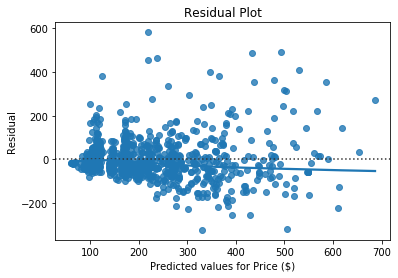

In [36]:
params = {
  "n_estimators": 100,
  "max_depth": 5,
  "random_state": 42
}

log_rf(experimentID, "Second Run", params, X_train, X_test, y_train, y_test)

Check the UI to see how this appears.  Take a look at the artifact to see where the plot was saved.

Now, run a third run.

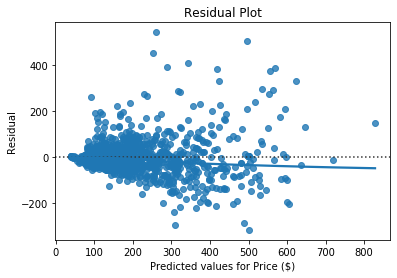

In [38]:
params_1000_trees = {
  "n_estimators": 1000,
  "max_depth": 10,
  "random_state": 42
}

log_rf(experimentID, "Third Run", params_1000_trees, X_train, X_test, y_train, y_test)

-sandbox
### Querying Past Runs

You can query past runs programatically in order to use this data back in Python.  The pathway to doing this is an `MlflowClient` object. 

<img alt="Side Note" title="Side Note" style="vertical-align: text-bottom; position: relative; height:1.75em; top:0.05em; transform:rotate(15deg)" src="https://files.training.databricks.com/static/images/icon-note.webp"/> You can also set tags for runs using `client.set_tag(run.info.run_uuid, "tag_key", "tag_value")`

In [40]:
from  mlflow.tracking import MlflowClient

client = MlflowClient()

Now list all the runs for your experiment using `.list_run_infos()`, which takes your `experiment_id` as a parameter.

In [42]:
client.list_run_infos(experimentID)

Out[25]: [<RunInfo: artifact_uri='dbfs:/databricks/mlflow/2604371717059921/e1d132fd22c044b7875ec65eabcbd39d/artifacts', end_time=1600409919475, experiment_id='2604371717059921', lifecycle_stage='active', run_id='e1d132fd22c044b7875ec65eabcbd39d', run_uuid='e1d132fd22c044b7875ec65eabcbd39d', start_time=1600409902006, status='FINISHED', user_id=''>,
 <RunInfo: artifact_uri='dbfs:/databricks/mlflow/2604371717059921/962add247d784ef299e3746ff42ce54b/artifacts', end_time=1600409874268, experiment_id='2604371717059921', lifecycle_stage='active', run_id='962add247d784ef299e3746ff42ce54b', run_uuid='962add247d784ef299e3746ff42ce54b', start_time=1600409871408, status='FINISHED', user_id=''>,
 <RunInfo: artifact_uri='dbfs:/databricks/mlflow/2604371717059921/0fa11f5113a6414b9095b73a99048336/artifacts', end_time=1600409841751, experiment_id='2604371717059921', lifecycle_stage='active', run_id='0fa11f5113a6414b9095b73a99048336', run_uuid='0fa11f5113a6414b9095b73a99048336', start_time=1600409839030, status='FINISHED', user_id=''>,
 <RunInfo: artifact_uri='dbfs:/databricks/mlflow/2604371717059921/7784725b926241de9295a9c30cdbcba3/artifacts', end_time=1600409796271, experiment_id='2604371717059921', lifecycle_stage='active', run_id='7784725b926241de9295a9c30cdbcba3', run_uuid='7784725b926241de9295a9c30cdbcba3', start_time=1600409793115, status='FINISHED', user_id=''>,
 <RunInfo: artifact_uri='dbfs:/databricks/mlflow/2604371717059921/f4172d57f40f4a7aa297314072136435/artifacts', end_time=1600408982695, experiment_id='2604371717059921', lifecycle_stage='active', run_id='f4172d57f40f4a7aa297314072136435', run_uuid='f4172d57f40f4a7aa297314072136435', start_time=1600408978692, status='FINISHED', user_id=''>]

Pull out a few fields and create a pandas DataFrame with it.

In [44]:
runs = pd.DataFrame([(run.run_uuid, run.start_time, run.artifact_uri) for run in client.list_run_infos(experimentID)])
runs.columns = ["run_uuid", "start_time", "artifact_uri"]

display(runs)

run_uuid,start_time,artifact_uri
e1d132fd22c044b7875ec65eabcbd39d,1600409902006,dbfs:/databricks/mlflow/2604371717059921/e1d132fd22c044b7875ec65eabcbd39d/artifacts
962add247d784ef299e3746ff42ce54b,1600409871408,dbfs:/databricks/mlflow/2604371717059921/962add247d784ef299e3746ff42ce54b/artifacts
0fa11f5113a6414b9095b73a99048336,1600409839030,dbfs:/databricks/mlflow/2604371717059921/0fa11f5113a6414b9095b73a99048336/artifacts
7784725b926241de9295a9c30cdbcba3,1600409793115,dbfs:/databricks/mlflow/2604371717059921/7784725b926241de9295a9c30cdbcba3/artifacts
f4172d57f40f4a7aa297314072136435,1600408978692,dbfs:/databricks/mlflow/2604371717059921/f4172d57f40f4a7aa297314072136435/artifacts


Pull the last run and take a look at the associated artifacts.

In [46]:
last_run = runs.sort_values("start_time", ascending=False).iloc[0]

dbutils.fs.ls(last_run["artifact_uri"]+"/random-forest-model/")

Out[25]: [FileInfo(path='dbfs:/databricks/mlflow/4442749364359340/e1d62941b13e472bad2cc58a85f3c052/artifacts/random-forest-model/MLmodel', name='MLmodel', size=357),
 FileInfo(path='dbfs:/databricks/mlflow/4442749364359340/e1d62941b13e472bad2cc58a85f3c052/artifacts/random-forest-model/conda.yaml', name='conda.yaml', size=130),
 FileInfo(path='dbfs:/databricks/mlflow/4442749364359340/e1d62941b13e472bad2cc58a85f3c052/artifacts/random-forest-model/model.pkl', name='model.pkl', size=46653912)]

In [47]:
dbutils.fs.ls(last_run["artifact_uri"]+"/random-forest-model/")[0].path

Out[28]: 'dbfs:/databricks/mlflow/4442749364359340/e1d62941b13e472bad2cc58a85f3c052/artifacts/random-forest-model/MLmodel'

Return the evaluation metrics for the last run.

In [49]:
client.get_run(last_run.run_uuid).data.metrics

Out[29]: {'mae': 48.82679545743182, 'mse': 6013.141341974693, 'r2': 0.7063859458544959}

Reload the model and take a look at the feature importance.

In [51]:
dbutils.fs.ls(last_run.artifact_uri)

Out[30]: [FileInfo(path='dbfs:/databricks/mlflow/4442749364359340/e1d62941b13e472bad2cc58a85f3c052/artifacts/feature-importance.csv/', name='feature-importance.csv/', size=0),
 FileInfo(path='dbfs:/databricks/mlflow/4442749364359340/e1d62941b13e472bad2cc58a85f3c052/artifacts/random-forest-model/', name='random-forest-model/', size=0),
 FileInfo(path='dbfs:/databricks/mlflow/4442749364359340/e1d62941b13e472bad2cc58a85f3c052/artifacts/residuals.png/', name='residuals.png/', size=0)]

In [52]:
import mlflow.sklearn

model = mlflow.sklearn.load_model(last_run.artifact_uri + "/random-forest-model/")
model.feature_importances_

Out[33]: array([0.02066125, 0.01968234, 0.01714745, 0.10652883, 0.0466081 ,
 0.0197694 , 0.04940956, 0.05043625, 0.09587796, 0.45534329,
 0.01225107, 0.00644477, 0.01970861, 0.03186636, 0.0288097 ,
 0.00256674, 0.00629972, 0.00134757, 0.0006453 , 0.00505837,
 0.00353737])

## Review
**Question:** What can MLflow Tracking log?  
**Answer:** MLflow can log the following:
- **Parameters:** inputs to a model
- **Metrics:** the performance of the model
- **Artifacts:** any object including data, models, and images
- **Source:** the original code, including the commit hash if linked to git

**Question:** How do you log experiments?  
**Answer:** Experiments are logged by first creating a run and using the logging methods on that run object (e.g. `run.log_param("MSE", .2)`).

**Question:** Where do logged artifacts get saved?  
**Answer:** Logged artifacts are saved in a directory of your choosing.  On Databricks, this would be DBFS, or the Databricks File System, which backed by a blob store.

**Question:** How can I query past runs?  
**Answer:** This can be done using an `MlflowClient` object.  This allows you do everything you can within the UI programatically so you never have to step outside of your programming environment.

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) Classroom-Cleanup<br>

Run the **`Classroom-Cleanup`** cell below to remove any artifacts created by this lesson.

In [55]:
%run "./Includes/Classroom-Cleanup"

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) Next Steps

Start the labs for this lesson, [Experiment Tracking Lab]($./Labs/02-Lab)

## Additional Topics & Resources

**Q:** What is MLflow at a high level?  
**A:** <a href="https://databricks.com/session/accelerating-the-machine-learning-lifecycle-with-mlflow-1-0" target="_blank">Listen to Spark and MLflow creator Matei Zaharia's talk at Spark Summit in 2019.</a>

**Q:** What is a good source for the larger context of machine learning tools?  
**A:** <a href="https://roaringelephant.org/2019/06/18/episode-145-alex-zeltov-on-mlops-with-mlflow-kubeflow-and-other-tools-part-1/#more-1958" target="_blank">Check out this episode of the podcast Roaring Elephant.</a>

**Q:** Where can I find the MLflow docs?
**A:** <a href="https://www.mlflow.org/docs/latest/index.html" target="_blank">You can find the docs here.</a>

**Q:** What is a good general resource for machine learning?  
**A:** <a href="https://www-bcf.usc.edu/~gareth/ISL/" target="_blank">_An Introduction to Statistical Learning_</a> is a good starting point for the themes and basic approaches to machine learning.

**Q:** Where can I find out more information on machine learning with Spark?
**A:** Check out the Databricks blog <a href="https://databricks.com/blog/category/engineering/machine-learning" target="_blank">dedicated to machine learning</a>

-sandbox
&copy; 2020 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="http://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="http://help.databricks.com/">Support</a>